## Exercise 1: Optimise lepton selection
In this first exercise the lepton selection will be optimised using Monte Carlo [MC] data

In [1]:
'''importing required libraries'''
from matplotlib import pyplot as plt
import numpy as np
import uproot
import awkward as ak
from scipy.optimize import curve_fit

In [20]:
'''defining functions to use later in the code. This cell does not need be understood right now and we advise to come back to it later'''

def plot_hist_of_arrays(list_of_arrays,
                        list_of_bins,
                        list_of_labels,
                        histtype='step',
                        xlabel='Enter X label!!',
                        ylabel='Counts',
                        xrange=None,
                        yrange=None,
                        title=None,
                        path_to_save_fig=False,
                        verbose=True
                        ):
    '''
    This function plots a histogram for a list of arrays
    :param list_of_arrays: input list of arrays to be plotted in a histogram
    :param list_of_bins: input list of bins to apply for the arrays for the histogram
    :param list_of_labels: input list of labels for the histograms
    :param histtype: step is the one we use here
    :param xlabel: string for label x axis of histogram
    :param ylabel: string for label y axis of histogram
    :param xrange: tuple for x range of histogram
    :param yrange: tuple for y range of histogram
    :param title: string for title of histogram
    :param path_to_save_fig: string for path to save histogram
    :param verbose:
    :return: bin content and bin edges for all input data
    '''
    counter = 0
    for array in list_of_arrays:
        if xrange:
            bin_content, bins_edges, _ = plt.hist(array, histtype=histtype, label=list_of_labels[counter],
                                                  bins=list_of_bins[counter], range=xrange)
        else:
            bin_content, bins_edges, _ = plt.hist(array, histtype=histtype, label=list_of_labels[counter],
                                                  bins=list_of_bins[counter])
        counter = counter + 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    if yrange:
        plt.ylim(yrange)
    if title:
        plt.title(title)
    if path_to_save_fig:
        plt.savefig(path_to_save_fig)
        if verbose:
            print(f'saving plot to {path_to_save_fig}')
    if verbose:
        plt.show()

    return bin_content, bins_edges


def get_efficiency_matrix(dic_data, cuts, variables):
    '''Calculates the acceptance matrix of the data arrays when applying cuts on the variables
    included in the dictionary. The errors of this matrix are determined via a Bayesian distribution
    and also returned.'''
    eff_matrix = np.zeros((4, 4))
    error_eff = np.zeros((4, 4))
    decay_modes = ['ee', 'mm', 'tt', 'qq']
    for (i, decay_filter) in zip(range(4), decay_modes):  # decay_filter is the decay mode which should be filtered
        for (j, decay_general) in zip(range(4), decay_modes):  # decay_general is the general decay mode filtered by the
            # cuts of deacy_filter
            mymask = True  # start with a general mask
            for var in variables:
                mymask *= dic_data[j][var] >= cuts[decay_filter][var][0]  # cut the lower bound
                mymask *= dic_data[j][var] <= cuts[decay_filter][var][
                    1]  # cut the upper bound and multiply boolean arrays
            number_passed_events = sum(mymask)
            total_number_events = len(mymask)
            eff_matrix[i][j] = number_passed_events / total_number_events  # efficiency
            variance = (number_passed_events + 1) * (number_passed_events + 2) / (total_number_events + 2) / (
                    total_number_events + 3) - (number_passed_events + 1) ** 2 / (total_number_events + 2) ** 2
            error_eff[i][j] = np.sqrt(variance)
    return eff_matrix, error_eff


def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))


def s_and_t_channel(cos_theta, A, B):
    return A * (1 + cos_theta ** 2) + B * (1 - cos_theta) ** (-2)


def s_channel(cos_theta, A):
    return A * (1 + cos_theta ** 2)


def t_channel(cos_theta, B):
    return B * (1 - cos_theta) ** (-2)

def integral_s_all(S):
    return 8 / 3 * S

def integral_tands_range(S, T):
    return 6443 / 3000 * S + 17 / 6 * T

def apply_cuts(dic_cuts, dic_data, cos_theta=True):
    '''Returns dictionary of data masks for all decay modes listed in dic_cuts'''
    decay_modes = dic_cuts.keys()
    if cos_theta:
        variables_with_cuts = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal', 'cos_thet']  # all variables that have cuts
    else:
        variables_with_cuts = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']  # all variables that have cuts
    dic_masks = {}
    for mode in decay_modes:
        mask = True
        for var in variables_with_cuts:
            mask *= dic_data[var] >= dic_cuts[mode][var][0]
            mask *= dic_data[var] <= dic_cuts[mode][var][1]
        dic_masks[mode] = mask
    return dic_masks

def import_dictionary(path_to_dictionary, verbose=True):
    if verbose:
        print(f'importing dictionary from {path_to_dictionary}')
    return np.load(path_to_dictionary, allow_pickle=True).item()


First the data from the MC simulation need to be opened. This is done by using uproot. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

The date is next converted into directories for better accessibility later in the code.
In this first Part of the code only the variables Pcharged, Ncharged, E_ecal, and E_hcal will be investigated. The beam Energy $E_\mathrm{lep} = 45.64\  GeV$

In [3]:
path_to_base_dir = 'Data/'

'''read MC files using uproot'''
ee_data = uproot.open(path_to_base_dir + 'ee.root')
mm_data = uproot.open(path_to_base_dir + 'mm.root')
tt_data = uproot.open(path_to_base_dir + 'tt.root')
qq_data = uproot.open(path_to_base_dir + 'qq.root')

'''name the ttree name'''
ttree_name = 'myTTree'

'''Load branches into arrays'''
branches_ee = ee_data[ttree_name].arrays()
branches_mm = mm_data[ttree_name].arrays()
branches_tt = tt_data[ttree_name].arrays()
branches_qq = qq_data[ttree_name].arrays()

# create a list to go through different variables
variables = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']

''' The list of branches in th TTree (i.e. list of variable names) may be printed with the below command'''
# print(ee_data[ttree_name].keys())

' The list of branches in th TTree (i.e. list of variable names) may be printed with the below command'

In [4]:
'''create an array of all decay types investigated'''
decay_types = ['electron', 'myon', 'tauon', 'hadron']

'''create dictionaries for each decay product'''
ee_dic = {}
mm_dic = {}
tt_dic = {}
qq_dic = {}

'''fill dictionaries'''
for var in variables:
    ee_dic[var] = ak.to_numpy(branches_ee[var])
    mm_dic[var] = ak.to_numpy(branches_mm[var])
    tt_dic[var] = ak.to_numpy(branches_tt[var])
    qq_dic[var] = ak.to_numpy(branches_qq[var])

'''combine all dictionarys into one large dictionary'''
all_dic = [ee_dic, mm_dic, tt_dic, qq_dic]

'''Create arrays for each variable which has the data for all 4 decay types'''
Pcharged = []
Ncharged = []
E_ecal = []
E_hcal = []

'''add data using the dictionary into the above created arrays'''
for dic in all_dic:
    Pcharged.append(dic[variables[0]])
    Ncharged.append(dic[variables[1]])
    E_ecal.append(dic[variables[2]])
    E_hcal.append(dic[variables[3]])

Next the histograms for all four investigated variables are plotted. Through looking at the graphs and the preliminary insights from the grope analysis the initial guess for the cuts are defined. Further info on the plotting method may be found in the documentation of the function at the beginning of this document.

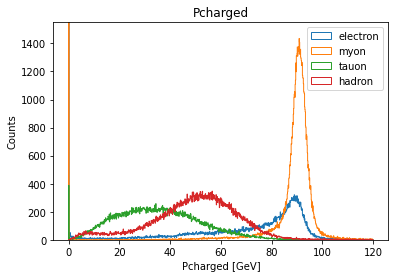

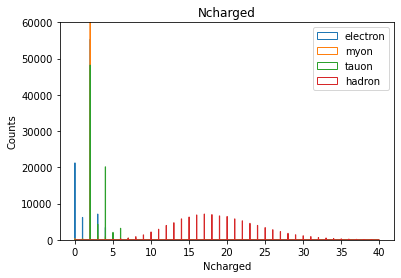

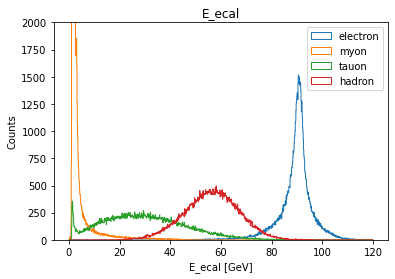

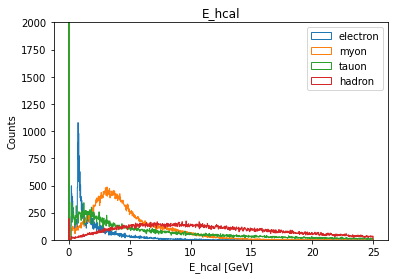

In [5]:
plot_hist_of_arrays(list_of_arrays=Pcharged,
                    list_of_labels=decay_types,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='Pcharged',
                    xrange=(0, 120),
                    yrange=(0, 1550),
                    xlabel='Pcharged [GeV]'
                    )
plot_hist_of_arrays(list_of_arrays=Ncharged,
                    list_of_labels=decay_types,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='Ncharged',
                    xrange=(0, 40),
                    yrange=(0, 60000),
                    xlabel='Ncharged'
                    )
plot_hist_of_arrays(list_of_arrays=E_ecal,
                    list_of_labels=decay_types,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='E_ecal',
                    xrange=(0, 120),
                    yrange=(0, 2000),
                    xlabel='E_ecal [GeV]'
                    )
plot_hist_of_arrays(list_of_arrays=E_hcal,
                    list_of_labels=decay_types,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='E_hcal',
                    xrange=(0, 25),
                    yrange=(0, 2000),
                    xlabel='E_hcal [GeV]'
                    )

'''create dictionary for cuts definition'''
cuts_initial = {'ee': {}, 'mm': {}, 'tt': {}, 'qq': {}}

'''cuts manually defined by looking at the graphs'''
cuts_initial['ee'] = {'Ncharged': (0, 6),
                      'Pcharged': (0, 120),
                      'E_ecal': (70, 120),
                      'E_hcal': (0, 10)}
cuts_initial['mm'] = {'Ncharged': (0, 6),
                      'Pcharged': (0, 120),
                      'E_ecal': (0, 15),
                      'E_hcal': (0, 10)}
cuts_initial['tt'] = {'Ncharged': (0, 6),
                      'Pcharged': (0, 60),
                      'E_ecal': (0, 60),
                      'E_hcal': (0, 120)}
cuts_initial['qq'] = {'Ncharged': (6, 60),
                      'Pcharged': (0, 120),
                      'E_ecal': (40, 80),
                      'E_hcal': (0, 120)}

To be able to quantify the cuts guesses an efficiency matrix is computed. This can also later be applied in the analysis to take the cutting into account. Further information on the efficiency matrix may be seen at the documentation of the function at the top of this document.

In [6]:
eff_matrix_initial, error_eff_initial = get_efficiency_matrix(all_dic, cuts_initial, variables=variables)
print(f'initial cut guess efficiency matrix:')
print(eff_matrix_initial)
print(error_eff_initial)

initial cut guess efficiency matrix:
[[9.69989979e-01 0.00000000e+00 1.01497210e-02 2.84082262e-04]
 [0.00000000e+00 8.92722052e-01 1.37235842e-01 0.00000000e+00]
 [3.55003092e-03 6.31165171e-02 8.74037418e-01 4.10904701e-03]
 [4.26430140e-05 0.00000000e+00 2.03625622e-02 9.06699268e-01]]
[[5.57152435e-04 1.05950161e-05 3.56339800e-04 5.46273547e-05]
 [1.06604126e-05 1.00734675e-03 1.22259556e-03 1.01454863e-05]
 [1.94480026e-04 7.91580007e-04 1.17893681e-03 2.04005458e-04]
 [2.38368989e-05 1.05950161e-05 5.01956541e-04 9.26462447e-04]]


Next the cuts were changed in order to optimise the efficiency matrix. An ideal efficiency Matrix has the form of a normal Matrix. Therefore, our aim was to have the diagonal elements as close as possible to 1, while having the lowest possible off diagonal elements. The error matrix was aimed to, at the same time, contain values as small as possible. After many revisions the below documented values were decided on. Comments on some values may be found below. In a larger setting these cut values may be found by using an optimisation function, however this extends the scope of the fp2 experiment.

In [7]:
cuts_final = {'ee': {}, 'mm': {}, 'tt': {}, 'qq': {}}

# cuts optimised by looking at the graphs individually
cuts_final['ee'] = {'Ncharged': (0, 6),
                    'Pcharged': (0, 120),
                    'E_ecal': (70, 120),
                    'E_hcal': (0, 10)}  # we tried reducing to (0, 8), but this only reduced the tau assignment minorly, but cut quite a few actual electrons
cuts_final['mm'] = {'Ncharged': (0, 6),
                    'Pcharged': (60, 120),
                    # this was the key to eliminate the tauons that passed. This however cuts all muons at 0, which are 4494, which are 5%, but it was worth because it eliminates almost all tauons. Then we increased the other windows to get the muons back up to 90%
                    'E_ecal': (0, 20),
                    'E_hcal': (0, 15)}
cuts_final['tt'] = {'Ncharged': (0, 6),
                    'Pcharged': (1, 70),
                    # with setting lower bound to 1, most muons (at 0) disappeared, opening to 70 increased tauons a lot
                    'E_ecal': (0, 80),  # opening to to 80 only increased tauons but not the others
                    'E_hcal': (0, 120)}
cuts_final['qq'] = {'Ncharged': (6, 60),
                    'Pcharged': (1, 120),
                    'E_ecal': (35, 90),  # this increased the acceptance of hadrons
                    'E_hcal': (1, 120)}

'''Again the Efficiency Matrix is computed. '''
eff_matrix_final, error_eff_final = get_efficiency_matrix(all_dic, cuts_final, variables=variables)
print(f'final cut guess efficiency matrix:')
print(eff_matrix_final)
print(error_eff_final)

final cut guess efficiency matrix:
[[9.69989979e-01 0.00000000e+00 1.01497210e-02 2.84082262e-04]
 [0.00000000e+00 9.02681684e-01 8.09200394e-03 0.00000000e+00]
 [1.31980128e-02 3.01119929e-02 9.53215341e-01 4.98158538e-03]
 [4.26430140e-05 0.00000000e+00 2.38972909e-02 9.48915922e-01]]
[[5.57152435e-04 1.05950161e-05 3.56339800e-04 5.46273547e-05]
 [1.06604126e-05 9.64789137e-04 3.18555304e-04 1.01454863e-05]
 [3.72756053e-04 5.56353619e-04 7.50392609e-04 2.24476555e-04]
 [2.38368989e-05 1.05950161e-05 5.42774483e-04 7.01341784e-04]]


In [8]:
'''Finally the difference in the efficiency matrix, due to our optimisation may be observed by calculating the difference between the initial and final efficiency matrix'''

print(np.abs(eff_matrix_final-eff_matrix_initial))

[[0.         0.         0.         0.        ]
 [0.         0.00995963 0.12914384 0.        ]
 [0.00964798 0.03300452 0.07917792 0.00087254]
 [0.         0.         0.00353473 0.04221665]]


From the above result one can observe, that the efficiency matrix was optimised quite a lot by our cut selection. The final efficiency matrix has values of over 90% on the diagonal, and errors that are all smaller than 4% (IS THAT CORRECT???)

Later, the inverse of the (final) efficiency matrix is used to correct for the cuts definition. In order to calculate the corresponding errors as well, the uncertainty of the inverse of the matrix has to be calculated. As Outlined in (<!-- [Text](link) --> [Propagation of Errors for Martrix inversion](https://arxiv.org/abs/hep-ex/9909031v1)) an analytical formula is not sufficient. Therefore the following way is used: Random efficiency matrices are generated, inverted and statistics are determined via a gaussian fit to each matrix element.


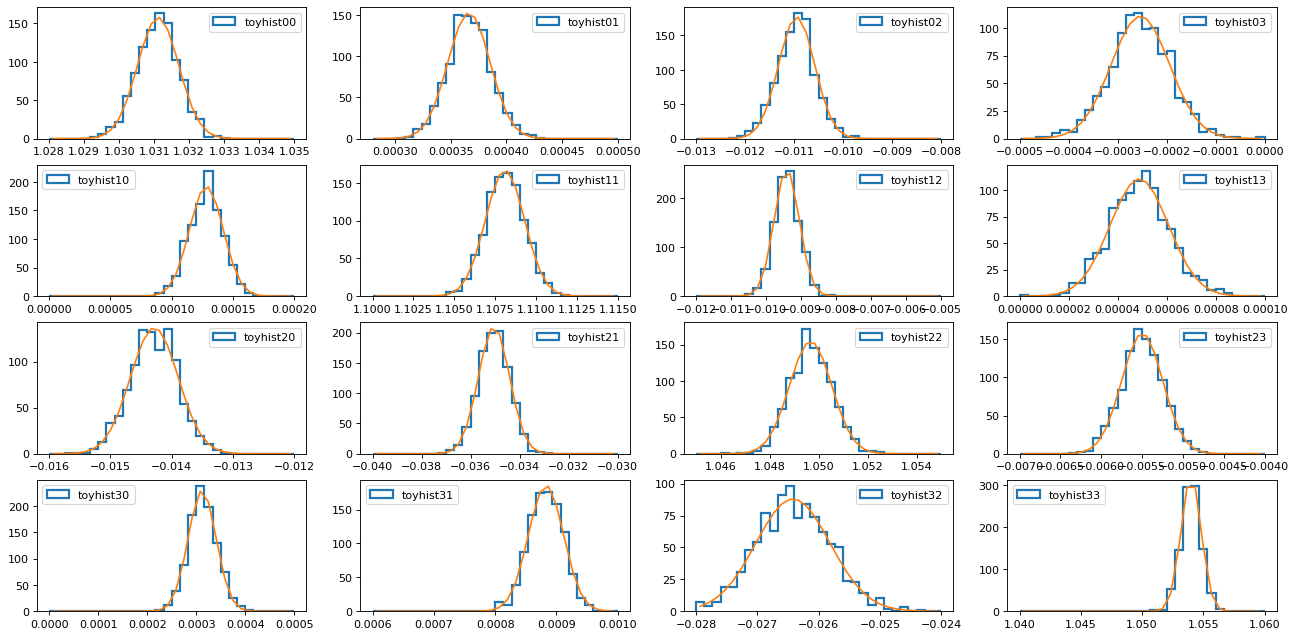

Errors for the inverse matrix:
[[5.87732759e-04 1.89339977e-05 3.68668148e-04 5.95969443e-05]
 [1.37966396e-05 1.19700908e-03 3.56580139e-04 1.19241531e-05]
 [3.90259147e-04 6.35056187e-04 8.63090954e-04 2.51516098e-04]
 [2.85564448e-05 2.88010587e-05 6.05721767e-04 8.23830988e-04]]


In [9]:
'''Number of toy experiments to be done'''
ntoy = 1000

'''Create numpy matrix of list to append elements of inverted toy matrices'''
inverse_toys = np.empty((4, 4))

'''Create toy efficiency matrix out of gaussian-distributed random values'''
for i in range(0, ntoy, 1):
    toy_matrix = np.zeros((4, 4))
    toy_matrix = np.random.normal(eff_matrix_final, error_eff_final, size=(4, 4))

    '''Invert toy matrix'''
    inverse_toy = np.linalg.inv(toy_matrix)
    inverse_toys = np.dstack((inverse_toys, inverse_toy))


'''Create numpy matrix to append elements for the inverse errors and means'''
inverse_errors = np.zeros((4, 4))
inverse_means = np.zeros((4, 4))

'''plot all 16 plots for the error matrix'''
fig = plt.figure(figsize=(20, 10), dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4, 4, 1)
ax01 = plt.subplot(4, 4, 2)
ax02 = plt.subplot(4, 4, 3)
ax03 = plt.subplot(4, 4, 4)

ax10 = plt.subplot(4, 4, 5)
ax11 = plt.subplot(4, 4, 6)
ax12 = plt.subplot(4, 4, 7)
ax13 = plt.subplot(4, 4, 8)

ax20 = plt.subplot(4, 4, 9)
ax21 = plt.subplot(4, 4, 10)
ax22 = plt.subplot(4, 4, 11)
ax23 = plt.subplot(4, 4, 12)

ax30 = plt.subplot(4, 4, 13)
ax31 = plt.subplot(4, 4, 14)
ax32 = plt.subplot(4, 4, 15)
ax33 = plt.subplot(4, 4, 16)

axes = [[ax00, ax01, ax02, ax03],
        [ax10, ax11, ax12, ax13],
        [ax20, ax21, ax22, ax23],
        [ax30, ax31, ax32, ax33]]

'''Adapted ranges to fit/plot gaussian distributions successfully'''
ranges = [[(1.028, 1.035), (0.00028, 0.0005), (-0.013, -0.008), (-0.0005, 0)],
          [(0, 0.0002), (1.1, 1.115), (-0.012, -0.005), (0, 0.0001)],
          [(-0.016, -0.012), (-0.04, -0.03), (1.045, 1.055), (-0.007, -0.004)],
          [(0, 0.0005), (0.0006, 0.001), (-0.028, -0.024), (1.04, 1.06)]]

'''Fill histograms for each inverted matrix coefficient:'''
for j in range(0, 4, 1):
    for k in range(0, 4, 1):
        '''Diagonal and off-diagonal terms have different histogram ranges'''
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j, k, :], bins=30, range=ranges[j][k], histtype='step',
                                           linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        '''Guess initial parameters of the fit by taking random value from hist and std'''
        _p0 = [ntoy / 10., np.mean(inverse_toys[j, k, :]), np.std(inverse_toys[j, k, :])]

        '''Get the fitted curve'''
        h_mid = 0.5 * (hedges[1:] + hedges[:-1])  # Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, p0=_p0, maxfev=100000)
        h_fit = gauss(h_mid, *coeffs)

        axes[j][k].plot(h_mid, h_fit, label=f'Fit{j}{k}')

        inverse_means[j, k] = coeffs[1]
        inverse_errors[j, k] = abs(coeffs[2])
plt.show()

print(f"Errors for the inverse matrix:\n{inverse_errors}")
inv_eff_matrix = np.linalg.inv(eff_matrix_final)

# Exercise 2: Separate $t$- and $s$-channel contributions
Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The electron (only electron!) MC sample incorporate contributions from $t$- and $s$-channels.  The aim of this part is to separate the $t$-channel contribution from the $s$-channel contribution. Here, the polar angle $\theta$ may be used for separation. The relative size of the $t$-channel amplitude depends on $\cos(\theta)$ (here referred to as ```cos_theta```). For high values this channel so becomes a major component. Therefore, the angle is plotted and fits for both the $s$- as well the $t$-channel as well as their combination are fitted. A cut is defined visually. Detailed information about functions used here, amy be found in the documetnation at the beginning of this document.

[-8.5578871e-01 -3.6037236e-01  9.9900000e+02 ...  7.3445606e-01
 -8.6465836e-01  8.7902808e-01]
S= 23.776403585063825 $\pm$ 0.15201159312641754 
 T= 1.3055122823879337 $\pm$ 0.012262126466743517


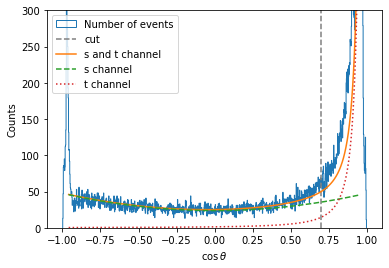

In [11]:
'''extract cos(theta) values as an array from detector data'''
cos_thet = ak.to_numpy(branches_ee['cos_thet'])

'''plot cos(theta) values (This corresponds to the differential crosssection), xlim to one, large number of values with number 999 correspond to detection errors. We believe, that the amount of detection errors is unphysical, and may result from not optimised experimental conditions.'''
print(cos_thet)
bin_content, bin_edges = plot_hist_of_arrays([cos_thet], [1000],
                                             ['Number of events'], yrange=(0, 300), xrange=(-1, 1),
                                             xlabel=r'$\cos{\theta}$', verbose=False)


'''Calculate midpoint of the bars'''
bin_mid = 0.5 * (bin_edges[1:] + bin_edges[:-1])

'''def start and end position (relative to cos(theta) array position) for fit'''
start_fit = 20
end_fit = -20

'''fit cos(theta) with s and t channel fit, definition of the fits are at the top of this document'''
coeffs_st, covariance_st = curve_fit(s_and_t_channel, bin_mid[start_fit:end_fit], bin_content[start_fit:end_fit],
                                     sigma=np.sqrt(bin_content[start_fit:end_fit]), absolute_sigma=True)

'''determine the (uncorrelated) uncertainties of the fit parameters'''
errors_st_fit = np.sqrt(np.diag(covariance_st))

'''Calculate chi squared/dof for the fit'''
chi_sqrd_fit = np.sum((bin_content[start_fit:end_fit] - s_and_t_channel(bin_mid[start_fit:end_fit], *coeffs_st)) ** 2
                      / np.sqrt(bin_content[start_fit:end_fit]) ** 2) / len(
    bin_content[start_fit:end_fit])

'''Print results for fit parameters'''
print('S=', coeffs_st[0], r'$\pm$', np.sqrt(covariance_st[0][0]), '\n', 'T=', coeffs_st[1], r'$\pm$',
      np.sqrt(covariance_st[1][1]))

'''define cut for t channel'''
cut = 0.70

plt.errorbar(bin_mid[start_fit:end_fit], s_and_t_channel(bin_mid[start_fit:end_fit], *coeffs_st), fmt='-',
             label='s and t channel')
plt.errorbar(bin_mid[start_fit:end_fit], s_channel(bin_mid[start_fit:end_fit], coeffs_st[0]), fmt='--',
             label='s channel')
plt.errorbar(bin_mid[start_fit:end_fit], t_channel(bin_mid[start_fit:end_fit], coeffs_st[1]), fmt=':',
             label='t channel')
plt.axvline(cut, label='cut', color='C7', ls='--')
plt.legend()
plt.show()


Here we picture the distribution of the measured values of cos(theta). Around 6/7 of the data points had a default 
value of 999, which were cut off in this histogram. The fit was not performed over the whole range of [-1, 1]
in order to neglect disturbing values at the boundaries and get a decent fit. We obtained the contributions
S=11.34 $\pm$ 0.10 of the $s$-channel and T=0.257 $\pm$ 0.006 of the $t$-channel. Based on the fit of both those 
contributions a cut at cos(theta)<=0.7 is chosen to select only $s$-channel events. However, this also cuts
some $s$-channel events with a higher value. To quantify how many we evaluate the following integrals. The total number of events that we identify as $s$-channel contribute to the integral of $s$- and $t$-channel in the interval [-1, 0.7].
The actual number of $s$-channel events can be determined by the integral of only the s-channel contribution between 
[-1, 1]. The ratio of this determines how we have to correct the number of $s$-channel events we found.

In [13]:
chosen_as_s = integral_tands_range(*coeffs_st)
actual_s = integral_s_all(coeffs_st[0])

'''simple error propagation'''
error_chosen_as_s = integral_s_all(errors_st_fit[0])  

'''error propagation with covariance of fit parameters'''
error_actual_s = np.sqrt(
    (6443 / 3000 * errors_st_fit[0]) ** 2 + (17 / 6 * errors_st_fit[1]) ** 2 + 2 * 6443 / 3000 * 17 / 6 *
    covariance_st[0][1])

'''ratio between actual and chosen s-channel events'''
correction_schannel = actual_s / chosen_as_s  

'''gaußian error propagagtion'''
error_correction_schannel = correction_schannel * np.sqrt(
    (error_actual_s / actual_s) ** 2 + (error_chosen_as_s / chosen_as_s) ** 2)  

print('Correction factor', correction_schannel, error_correction_schannel)

Correction factor 1.1577898010934304 0.0103759145780652


# Exercise 2b: Separate  𝑡 - and  𝑠 -channel contributions (with the detector data)

In addition to the sepatation of the $t$- and $s$-channels using the MC data, the separation was done using the detector data. Steps are analogue to the previous separation.

# Exercise 3: Measurement of the total production cross sections
